# Prestack seismic inversion - Volve data

This notebook aims at presenting an example of prestack seismic inversion.

We will use the Volve data as input data to our inversion and we will leverage the open-source segyio and pylops libraries to accomplish our task as follows:

- Data is read from SEG-Y file using segyio (note that for the Volve data we will have to deal with irregular geometry)
- Prestack inversion is applied by means of ``pylops.avo.poststack.PreStackInversion``
- Inverted data is saved back to SEG-Y file using segyio

We cannot provide the data given its size, but the Volve data is hosted on a Azure Blob storage so it is very easy to download it using the Azure CLI (https://github.com/Azure/azure-cli or ``pip install azure-cli`` would do).

First of all let's investigate what is present in the `Seismic` directory

In [1]:
#!az storage blob list --account-name dataplatformblvolve --container-name pub --prefix Seismic/ --sas-token "$YOURTOKEN" > ../data/seismicinversion/list_seismic.txt

In [2]:
!head -n 60 ../data/seismicinversion/list_seismic.txt

[
  {
    "content": null,
    "deleted": false,
    "metadata": null,
    "name": "Seismic/README.txt",
    "properties": {
      "appendBlobCommittedBlockCount": null,
      "blobTier": "Cool",
      "blobTierChangeTime": null,
      "blobTierInferred": true,
      "blobType": "BlockBlob",
      "contentLength": 1011,
      "contentRange": null,
      "contentSettings": {
        "cacheControl": null,
        "contentDisposition": null,
        "contentEncoding": null,
        "contentLanguage": null,
        "contentMd5": "VNB2po0tluppJS2dg4Y8WQ==",
        "contentType": "text/plain"
      },
      "copy": {
        "completionTime": null,
        "id": null,
        "progress": null,
        "source": null,
        "status": null,
        "statusDescription": null
      },
      "creationTime": "2018-05-14T09:37:35+00:00",
      "deletedTime": null,
      "etag": "0x8D5B97E533330A7",
      "lastModified": "2018-05-14T09:37:35+00:00",
      "lease": {
        "duration": null,
    

where you will need to substitute ``$YOURTOKEN`` with your personal token. To get a token, simply register at https://data.equinor.com/authenticate and find the token in the red text in the Usage section. Ensure to copy everything from `?sv=` to `=rl` in place of ``$YOURTOKEN``.

We can now download the file of interest

In [3]:
# TO BE RUN ONLY ONCE TO RETRIEVE THE DATA
#!az storage blob download --account-name dataplatformblvolve --container-name pub --name Seismic/ST10010/Stacks/SIKI.680346991.SEGY.00332.ST10010ZC11_PZ_PSDM_RMO_CIP_GATHS_D.3D.PRESTACK_BINGATHERS.000000010221.0001961.0002680 --file SIKI.680346991.SEGY.00332.ST10010ZC11_PZ_PSDM_RMO_CIP_GATHS_D.3D.PRESTACK_BINGATHERS.000000010221.0001961.0002680 --sas-token "$YOURTOKEN"
#!mv SIKI.680346991.SEGY.00332.ST10010ZC11_PZ_PSDM_RMO_CIP_GATHS_D.3D.PRESTACK_BINGATHERS.000000010221.0001961.0002680 ../data/avo

Let's first import all the libraries we need

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import time
import os
import sys
import numpy as np
import segyio
import pylops
import matplotlib.pyplot as plt
import offsettoangle

from scipy.interpolate import RegularGridInterpolator, interp1d

And define some of the input parameters we will use later (refer to the following for a more detailed description of the types of inversion)

In [152]:
# Data
itmin = 300 # index of first time/depth sample in data used in inversion
itmax = 1000 # index of last time/depth sample in data used in inversion

# Subsampling (can save file at the end only without subsampling)
jt = 1
jil = 1
jxl = 1

# Wavelet estimation
nt_wav = 21 # number of samples of statistical wavelet
nfft = 512 # number of samples of FFT

# Trace-by-Trace Inversion
epsI_tt = 1e-3 # damping

# Spatially simultaneous
niter_sr = 3 # number of iterations of lsqr
epsI_sr = 1e-4 # damping
epsR_sr = 1e2 # spatial regularization

# Blocky simultaneous
niter_out_b = 3 # number of outer loop iterations
niter_in_b = 1 # number of inner loop iterations
niter_b = 10 # number of iterations of lsqr
mu_b = 1e-1 # damping for data term
epsI_b = 1e-4 # damping
epsR_b = 0.1 # spatial regularization
epsRL1_b = 0.2 # blocky regularization

### Data loading

Let's now read the Volve data.

Note that we add the `ignore_geometry=True` parameter when we open the file. As we will see the geometry in this file is not regular, so we cannot rely on the inner working of segyio to get our data into a 3d numpy.

We thus need to read all ILs, XLs and traces and reorganize them ourselves into a regular grid. No worries, numpy will do most of the hard work.

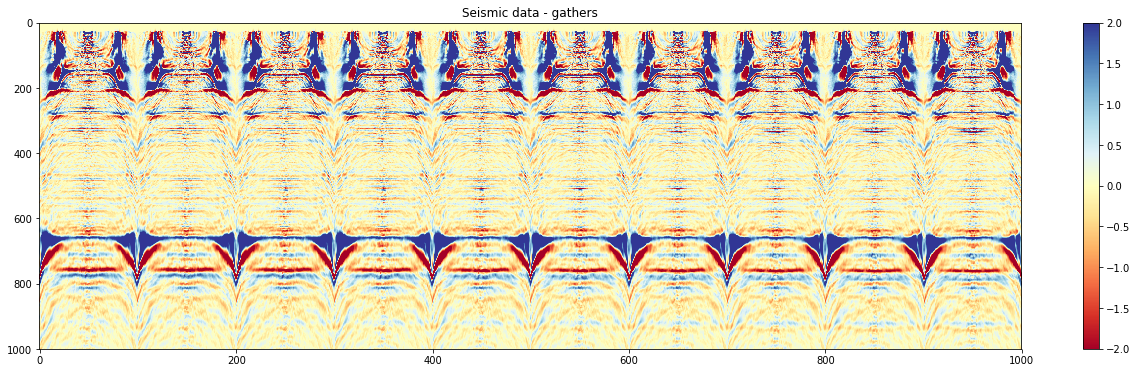

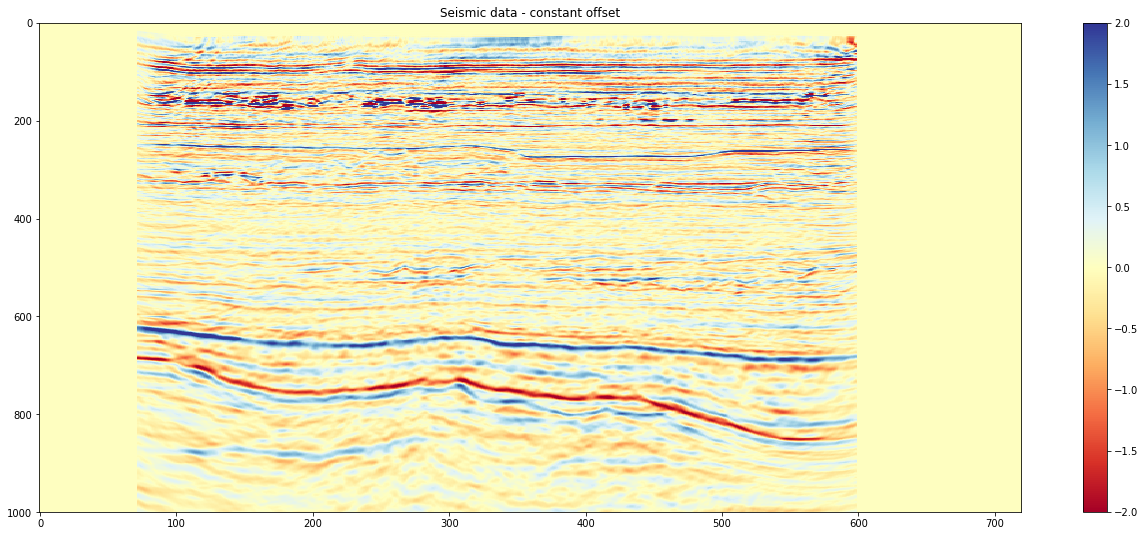

In [25]:
# depth domain seismic
segyfile = '../data/avo/SIKI.680346991.SEGY.00332.ST10010ZC11_PZ_PSDM_RMO_CIP_GATHS_D.3D.PRESTACK_BINGATHERS.000000010221.0001961.0002680'

f = segyio.open(segyfile, ignore_geometry=True)

traces = segyio.collect(f.trace)[:]
traces = traces[:, :itmax]
ntraces, nt = traces.shape

t = f.samples[:itmax]
il = f.attributes(segyio.TraceField.INLINE_3D)[:]
xl = f.attributes(segyio.TraceField.CROSSLINE_3D)[:]
off = f.attributes(segyio.TraceField.offset)[:]

# Define regular IL and XL axes
il_unique = np.unique(il)
xl_unique = np.unique(xl)
off_unique = np.unique(off)

xl_min, xl_max = min(xl_unique), max(xl_unique)
off_min, off_max = min(off_unique), max(off_unique)

dt = t[1] - t[0]
dxl = min(np.unique(np.diff(xl_unique)))
doff = min(np.unique(np.diff(off_unique)))

xlines = np.arange(xl_min, xl_max + dxl, dxl)
offsets = np.arange(off_min, off_max + doff, doff)
nxl, noff = xlines.size, offsets.size

xlgrid, offgrid = np.meshgrid(np.arange(nxl),
                              np.arange(noff),
                              indexing='ij')

# Look-up table
traces_indeces = np.full((nxl, noff), np.nan)
ixls = (xl - xl_min) // dxl
ioffs = (off - off_min) // doff
traces_indeces[ixls, ioffs] = np.arange(ntraces)
traces_available = np.logical_not(np.isnan(traces_indeces))

# Reorganize traces in regular grid
d = np.zeros((nxl, noff, nt))
d[xlgrid.ravel()[traces_available.ravel()],
  offgrid.ravel()[traces_available.ravel()]] = traces

# Subsample
d = d[::jxl, :, ::jt]
xlines = xlines[::jxl]
t = t[::jt]
nxl, nt = len(xlines), len(t)

# Display data
plt.figure(figsize=(22, 6))
plt.imshow((d.reshape(nxl*noff, nt).T)[:, nxl*noff//2-500:nxl*noff//2+500], cmap='RdYlBu', vmin=-2, vmax=2)
plt.title('Seismic data - gathers')
plt.colorbar()
plt.axis('tight')

# Display data
plt.figure(figsize=(22, 9))
plt.imshow(d[:, noff-40].T, cmap='RdYlBu', vmin=-2, vmax=2)
plt.title('Seismic data - constant offset')
plt.colorbar()
plt.axis('tight');

We can now remove those far offsets where we do not always have access to data

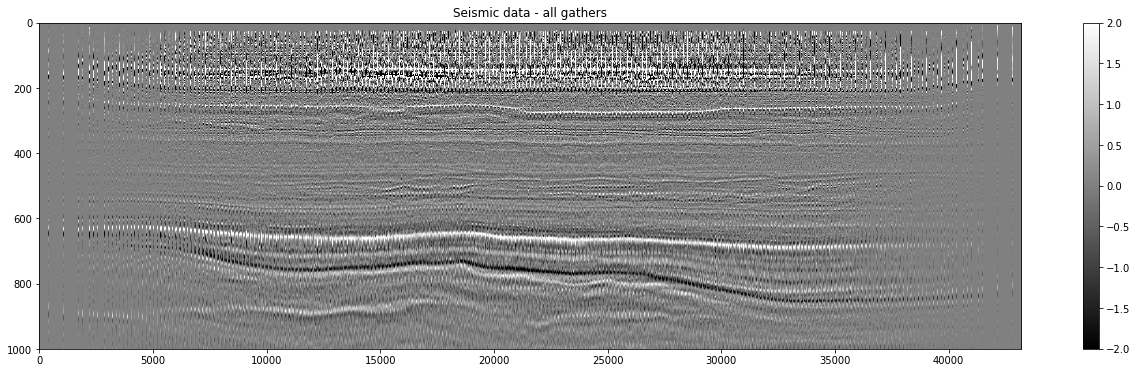

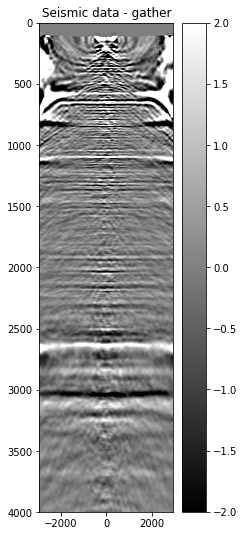

In [26]:
# Subsample
ioffedges = 20
d = d[:, ioffedges:-ioffedges]
offsets = offsets[ioffedges:-ioffedges]
noff = offsets.size

# Display data
plt.figure(figsize=(22, 6))
plt.imshow(d.reshape(nxl*noff, nt).T, cmap='gray', vmin=-2, vmax=2)
plt.title('Seismic data - all gathers')
plt.colorbar()
plt.axis('tight');

# Display data
plt.figure(figsize=(3, 9))
plt.imshow(d[nxl//2].T, cmap='gray', vmin=-2, vmax=2, interpolation='sinc',
           extent=(offsets[0], offsets[-1], t[-1], t[0]))
plt.title('Seismic data - gather')
plt.colorbar()
plt.axis('tight');

#plt.figure()
#plt.plot(d[nxl//2, :, int((2630-t[0])/dt)].T, 'k')
#plt.plot(d[nxl//2, :, int((3030-t[0])/dt)].T, 'r')
#plt.title('Single trace');

### Offset to angle conversion

We need to convert our offsets in angles. We will use a simple routine for this which requires access to the interval velocity

In [28]:
segyfilev = '../data/seismicinversion/ST10010ZC11-MIG-VEL.MIG_VEL.VELOCITY.3D.JS-017527.segy'
fv = segyio.open(segyfilev)
v = segyio.cube(fv)

# select inline
iil = np.where(fv.ilines == il_unique + 2)[0][0]
v = v[iil]

# interpolate in same grid as data
XL, T = np.meshgrid(xlines, t, indexing='ij')

v = RegularGridInterpolator((fv.xlines, fv.samples), v, bounds_error=False, fill_value=0)
v = v(np.vstack((XL.ravel(), T.ravel())).T)
v = v.reshape(nxl, nt)

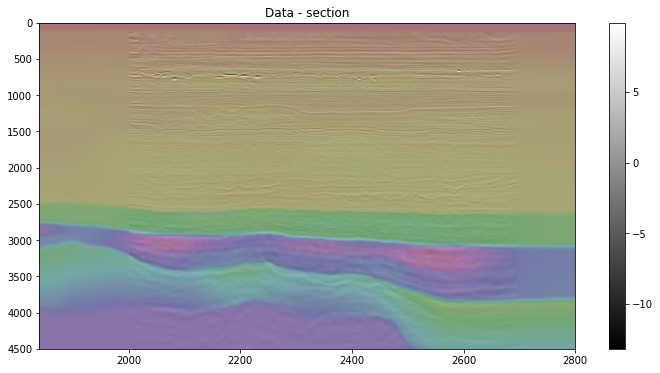

In [29]:
# Display data
plt.figure(figsize=(12, 6))
im = plt.imshow(d[:, noff-40].T, cmap='gray',
                extent=(fv.xlines[0], fv.xlines[-1], fv.samples[-1], fv.samples[0]))
plt.imshow(v.T, cmap='gist_rainbow', alpha=0.2,
           extent=(fv.xlines[0], fv.xlines[-1], fv.samples[-1], fv.samples[0]))
plt.title('Data - section')
plt.colorbar(im)
plt.axis('tight');

In [30]:
def offsets_to_angles_time(offset, vint, dt, niters, percupdate_stop):
    """Offset to angle conversion in depth domain
    
    Parameters
    ----------
    offset : :obj:`np.ndarray`
        Offsets
    vint : :obj:`np.ndarray`
        Interval velocity in depth
    dz : :obj:`float`
        Time axis sampling
    niters : :obj:`float`
        Number of iterations
    percupdate_stop : :obj:`float`
        Percentage update (below which iterations are stopped)
   
    Returns
    -------
    theta : :obj:`np.ndarray`
        Angles in degrees
        
    """
    z = vint * dt/2
    ztot = np.sum(z)

    maxp0 = .9999 / np.max(vint)
    p0 = np.sin(np.arctan(offset/ztot))/vint[-1]
    p0[p0>maxp0] = maxp0
    p = p0
    for iidter in range(niters):
        Fp = np.sum((z * vint * p[:, np.newaxis]) / \
                    np.sqrt(1 - (p[:, np.newaxis]*vint)**2), axis=1) - offset / 2.
        Fp1 = np.sum((z * vint) / ((1 - (p[:, np.newaxis]*vint)**2)**1.5), axis=1)
        pupdate = Fp / Fp1
        p = p - pupdate.ravel()
        p[p>maxp0] = maxp0
    theta = np.rad2deg(np.arcsin(p * vint[-1]))
    return theta

def angles_to_offsets_time(theta, vint, dz):
    """Angle to offset conversion in depth domain (joint for whole depth axis)
    
    Parameters
    ----------
    theta : :obj:`float`
        Angle in degrees
    vint : :obj:`np.ndarray`
        Interval velocity in depth
    dz : :obj:`float`
        Depth axis sampling
   
    Returns
    -------
    offset : :obj:`float`
        Offset
        
    """
    p = np.sin(np.deg2rad(theta)) / vint[-1]
    z = vint * dt / 2.

    offset = 2 * np.sum((z * vint * p[:, np.newaxis]) / \
                        np.sqrt(1 - (p[:, np.newaxis] * vint)**2), axis=1)
    return offset

First find angles for all offsets

/private/mrava/miniconda3/envs/pylops/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in sqrt
/private/mrava/miniconda3/envs/pylops/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in power
/private/mrava/miniconda3/envs/pylops/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in greater


8.864470958709717


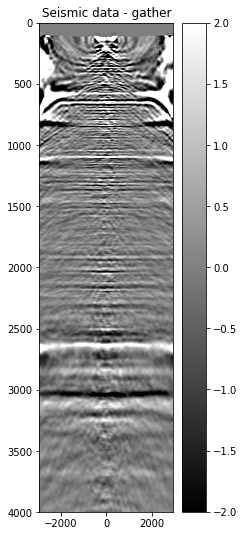

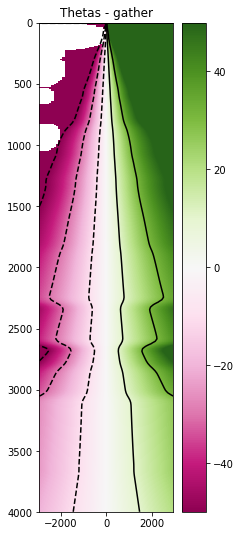

In [31]:
niters = 3
percupdate_stop=1e-5

t0=time.time()
thetas = np.zeros((nxl, noff, nt))
for ixl in range(nxl//2, nxl//2+1):
    for it in range(2, nt):
        thetas[ixl, :, it] = offsets_to_angles_time(offsets, v[ixl, :it], dt/1000., niters, percupdate_stop)
print(time.time()-t0)

plt.figure(figsize=(3, 9))
plt.imshow(d[nxl//2].T, cmap='gray', vmin=-2, vmax=2, interpolation='sinc',
           extent=(offsets[0], offsets[-1], t[-1], t[0]))
plt.title('Seismic data - gather')
plt.colorbar()
plt.axis('tight');

plt.figure(figsize=(3, 9))
im = plt.imshow(thetas[nxl//2].T, cmap='PiYG', vmin=-50, vmax=50, interpolation='sinc',
                extent=(offsets[0], offsets[-1], t[-1], t[0]))
plt.contour(offsets, t, thetas[nxl//2].T, colors='k', levels=np.arange(-50, 50, 20),
            vmin=-50, vmax=50, interpolation='sinc')
plt.title('Thetas - gather')
plt.colorbar(im)
plt.axis('tight');

Working on xline 0/720


/private/mrava/miniconda3/envs/pylops/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in sqrt
/private/mrava/miniconda3/envs/pylops/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in power
/private/mrava/miniconda3/envs/pylops/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in greater


Working on xline 10/720
Working on xline 20/720
Working on xline 30/720
Working on xline 40/720
Working on xline 50/720
Working on xline 60/720
Working on xline 70/720
Working on xline 80/720
Working on xline 90/720
Working on xline 100/720
Working on xline 110/720
Working on xline 120/720
Working on xline 130/720
Working on xline 140/720
Working on xline 150/720
Working on xline 160/720
Working on xline 170/720
Working on xline 180/720
Working on xline 190/720
Working on xline 200/720
Working on xline 210/720
Working on xline 220/720
Working on xline 230/720
Working on xline 240/720
Working on xline 250/720
Working on xline 260/720
Working on xline 270/720
Working on xline 280/720
Working on xline 290/720
Working on xline 300/720
Working on xline 310/720
Working on xline 320/720
Working on xline 330/720
Working on xline 340/720
Working on xline 350/720
Working on xline 360/720
Working on xline 370/720
Working on xline 380/720
Working on xline 390/720
Working on xline 400/720
Working o

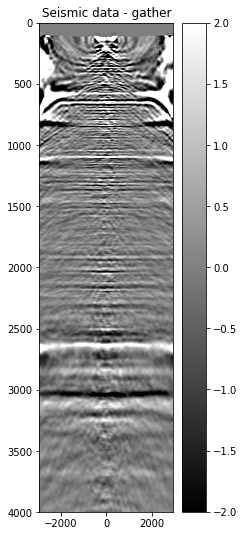

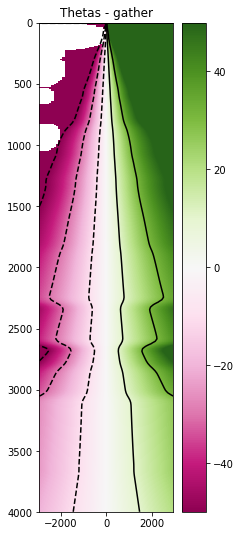

In [32]:
niters = 3
percupdate_stop=1e-5

t0=time.time()
thetas = np.zeros((nxl, noff, nt))
for ixl in range(nxl):
    if ixl % 10 == 0:
        print('Working on xline %d/%d' % (ixl, nxl))
    for it in range(2, nt):
        thetas[ixl, :, it] = offsets_to_angles_time(offsets, v[ixl, :it], dt/1000., niters, percupdate_stop)
print('Total time (s):', time.time() - t0)

plt.figure(figsize=(3, 9))
plt.imshow(d[nxl//2].T, cmap='gray', vmin=-2, vmax=2, interpolation='sinc',
           extent=(offsets[0], offsets[-1], t[-1], t[0]))
plt.title('Seismic data - gather')
plt.colorbar()
plt.axis('tight');

plt.figure(figsize=(3, 9))
im = plt.imshow(thetas[nxl//2].T, cmap='PiYG', vmin=-50, vmax=50, interpolation='sinc',
                extent=(offsets[0], offsets[-1], t[-1], t[0]))
plt.contour(offsets, t, thetas[nxl//2].T, colors='k', levels=np.arange(-50, 50, 20),
            vmin=-50, vmax=50, interpolation='sinc')
plt.title('Thetas - gather')
plt.colorbar(im)
plt.axis('tight');

Now reinterpolate the data from $d(xl, off, t)$ into $d(xl, \theta, t)$ 

In [ ]:
theta_reg = np.arange(-25, 25, 2)
ntheta = len(theta_reg)
dtheta = np.zeros((nxl, len(theta_reg), nt))

for ixl in range(nxl):
    for it in range(2, nt):
        #dtheta[ixl, :, it] = np.interp(theta_reg, thetas[ixl, :, it], d[ixl, :, it],
        #                               left=np.nan, right=np.nan)
        dtheta[ixl, :, it] = interp1d(thetas[ixl, :, it], 
                                      d[ixl, :, it], fill_value='extrapolate')(theta_reg)


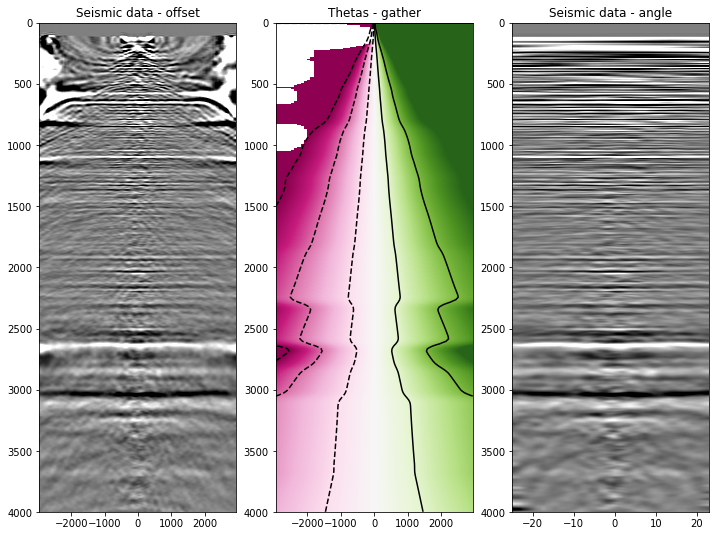

In [233]:
fig, axs = plt.subplots(1, 3, figsize=(12, 9))
axs[0].imshow(d[nxl//2].T, cmap='gray', vmin=-2, vmax=2, interpolation='sinc',
           extent=(offsets[0], offsets[-1], t[-1], t[0]))
axs[0].set_title('Seismic data - offset')
axs[0].axis('tight')

axs[1].imshow(thetas[nxl//2].T, cmap='PiYG', vmin=-50, vmax=50, interpolation='sinc',
                extent=(offsets[0], offsets[-1], t[-1], t[0]))
axs[1].contour(offsets, t, thetas[nxl//2].T, colors='k', levels=np.arange(-50, 50, 20),
            vmin=-50, vmax=50, interpolation='sinc')
axs[1].set_title('Thetas - gather')
axs[1].axis('tight');

axs[2].imshow(dtheta[nxl//2].T, cmap='gray', vmin=-2, vmax=2, interpolation='sinc',
           extent=(theta_reg[0], theta_reg[-1], t[-1], t[0]))
axs[2].set_title('Seismic data - angle')
axs[2].axis('tight');

### Wavelet estimation

Let's now try to get a quick estimate of the wavelet in our data using a simple statistical wavelet estimation in frequency domain.

Note that this notebook is not focused on the pre-processing but we will need access to this to apply a colored inversion.

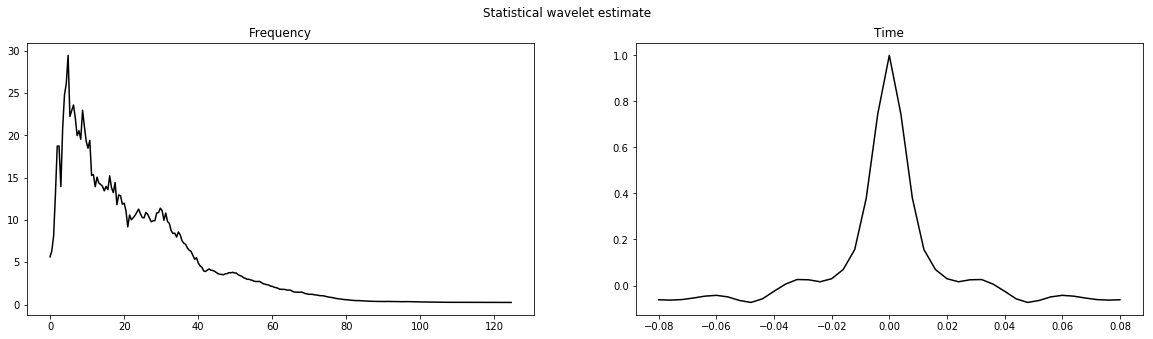

In [153]:
# Wavelet time axis
t_wav = np.arange(nt_wav) * (dt/1000)
t_wav = np.concatenate((np.flipud(-t_wav[1:]), t_wav), axis=0)

# Estimate wavelet spectrum
wav_est_fft = np.mean(np.abs(np.fft.fft(dtheta[..., itmin:], nfft, axis=-1)), axis=(0, 1))
fwest = np.fft.fftfreq(nfft, d=dt/1000)

# Create wavelet in time
wav_est = np.real(np.fft.ifft(wav_est_fft)[:nt_wav])
wav_est = np.concatenate((np.flipud(wav_est[1:]), wav_est), axis=0)
wav_est = wav_est / wav_est.max()

# Display wavelet
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Statistical wavelet estimate')
axs[0].plot(fwest[:nfft//2], wav_est_fft[:nfft//2], 'k')
axs[0].set_title('Frequency')
axs[1].plot(t_wav, wav_est, 'k')
axs[1].set_title('Time');

### Relative pre-stack inversion

In [154]:
# ensure angle gathers do not contain nan
dtheta[np.isnan(dtheta)] = 0 # need to find better way to handle this

In [155]:
minv_dense, dres_dense = \
    pylops.avo.prestack.PrestackInversion(np.swapaxes(dtheta[..., itmin:], 0, 2), theta_reg, wav_est, 
                                          linearization='akirich',
                                          explicit=True, returnres=True,
                                          **dict(cond=1e-2))

# spatially regularized lop inversion with noisy data
minv_reg, dres_reg = \
    pylops.avo.prestack.PrestackInversion(np.swapaxes(dtheta[..., itmin:], 0, 2), theta_reg, wav_est, 
                                          m0=minv_dense,
                                          explicit=False, linearization='akirich',
                                          epsR=5e2, returnres=True,
                                          **dict(damp=np.sqrt(1e-4),
                                                 iter_lim=20))

In [225]:
# blocky inversion
minv_blocky, dres_blocky = \
    pylops.avo.prestack.PrestackInversion(np.swapaxes(dtheta[..., itmin:], 0, 2), theta_reg, wav_est, 
                                          m0=minv_dense,
                                          explicit=False, linearization='akirich',
                                          epsR=0.2, epsRL1=0.1,
                                          returnres=True,
                                          **dict(mu=.1, niter_outer=10, 
                                                 niter_inner=2, show=True,
                                                 iter_lim=20, damp=1e-4))

Split-Bregman optimization
---------------------------------------------------------
The Operator Op has 12600000 rows and 1512000 cols
niter_outer =  10     niter_inner =   2   tol = 1.00e-10
mu = 1.00e-01         epsL1 = (0.1,)	  epsL2 = (0.2,)     
---------------------------------------------------------

   Itn          x[0]           r2norm          r12norm
     1  -4.86557e-03        3.229e+04        3.239e+05
     2  -5.03761e-03        3.177e+04        3.231e+05
     3  -3.94509e-03        3.142e+04        3.368e+05
     4  -2.47031e-03        3.130e+04        3.380e+05
     5  -1.08654e-03        3.123e+04        3.369e+05
     6   1.52656e-05        3.118e+04        3.356e+05
     7   8.65221e-04        3.115e+04        3.344e+05
     8   1.47799e-03        3.113e+04        3.334e+05
     9   1.88867e-03        3.111e+04        3.325e+05
    10   2.10513e-03        3.109e+04        3.318e+05

Iterations = 10        Total time (s) = 300.93
------------------------------------

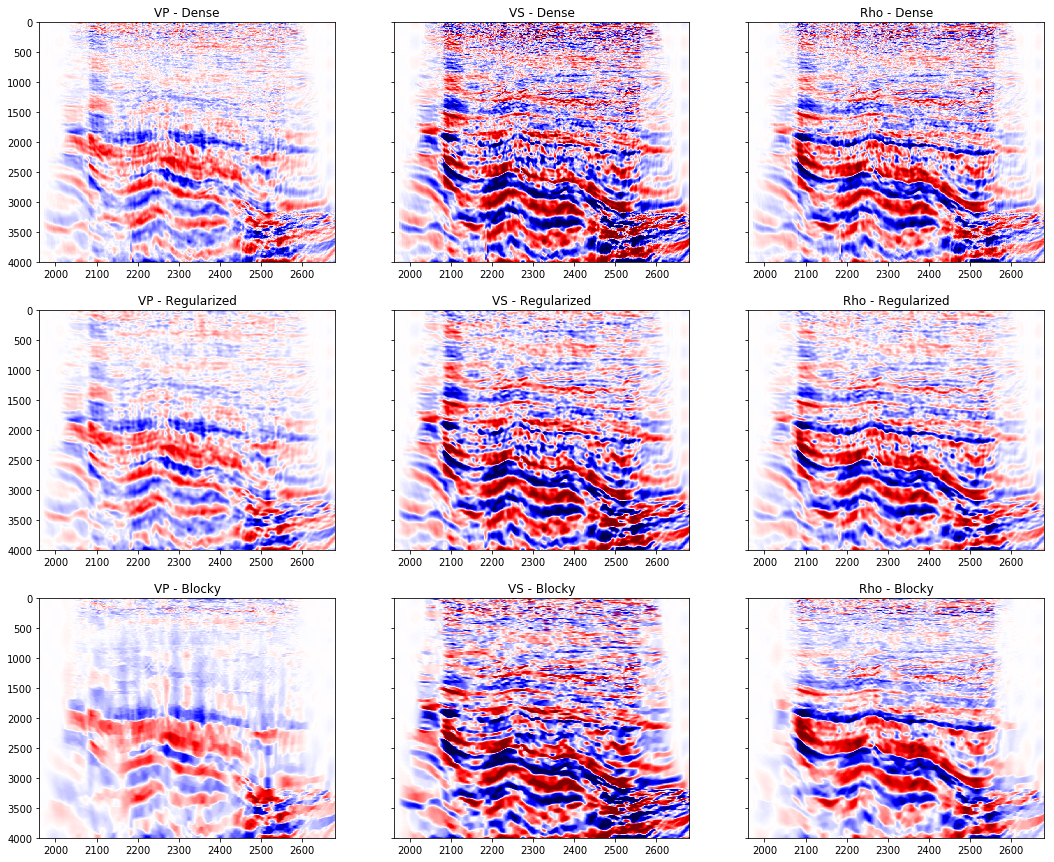

In [226]:
def plotmodel(axs, m, x, z, vmin, vmax,
              params=('VP', 'VS', 'Rho'),
              cmap='gist_rainbow', title=None):
    """Quick visualization of model
    """
    for ip, param in enumerate(params):
        axs[ip].imshow(m[:, ip],
                       extent=(x[0], x[-1], z[-1], z[0]),
                       vmin=vmin, vmax=vmax, cmap=cmap)
        axs[ip].set_title('%s - %s' %(param, title))
        axs[ip].axis('tight')
    plt.setp(axs[1].get_yticklabels(), visible=False)
    plt.setp(axs[2].get_yticklabels(), visible=False)


fig, axs = plt.subplots(3, 3, sharey=True, figsize=(18, 15))
plotmodel(axs[0], minv_dense, xl, t, -0.4*minv_dense.max(),
          0.4*minv_dense.max(),  cmap='seismic', title='Dense')
plotmodel(axs[1], minv_reg, xl, t, -0.4*minv_dense.max(),
          0.4*minv_dense.max(), cmap='seismic', title='Regularized')
plotmodel(axs[2], minv_blocky, xl, t, -0.4*minv_blocky.max(),
          0.4*minv_blocky.max(), cmap='seismic', title='Blocky')

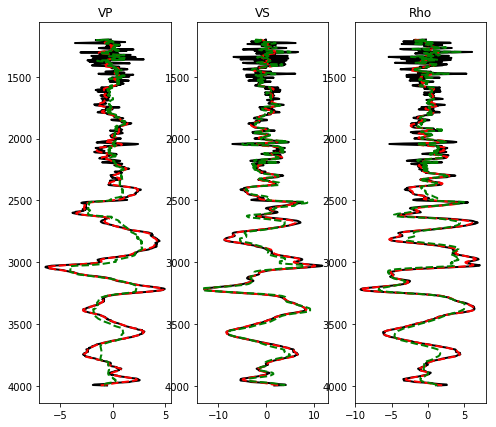

In [227]:
fig, axs = plt.subplots(1, 3, figsize=(8, 7))
for ip, param in enumerate(['VP', 'VS', 'Rho']):
    axs[ip].plot(minv_dense[:, ip, nxl//2], t[itmin:], 'k', lw=2)
    axs[ip].plot(minv_reg[:, ip, nxl//2], t[itmin:], '--r', lw=2)
    axs[ip].plot(minv_blocky[:, ip, nxl//2], t[itmin:], '--g', lw=2)
    axs[ip].set_title(param)
    axs[ip].invert_yaxis()

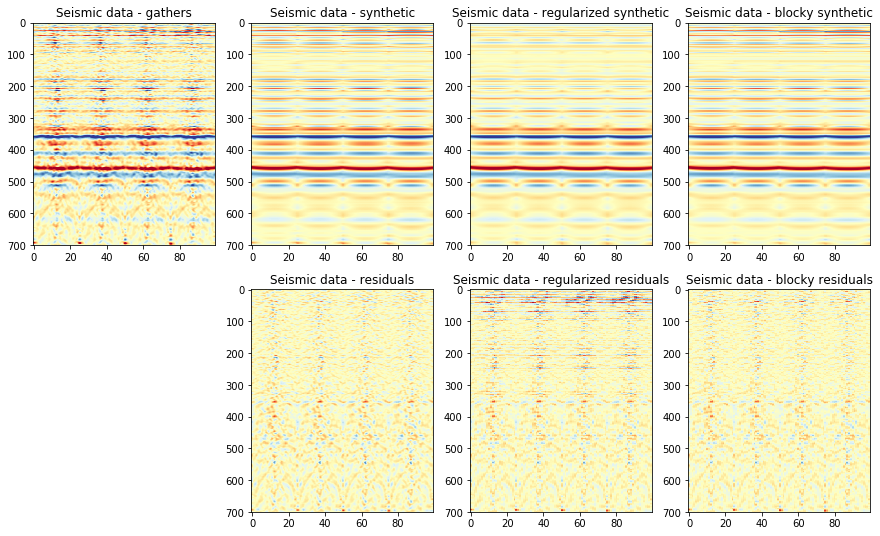

In [228]:
ntwin = itmax - itmin

fig, axs = plt.subplots(2, 4, figsize=(15, 9))
axs[0, 0].imshow((dtheta[..., itmin:].reshape(nxl*ntheta, ntwin).T)[:, nxl*ntheta//2-50:nxl*ntheta//2+50], 
           cmap='RdYlBu', interpolation='sinc', vmin=-2, vmax=2)
axs[0, 0].set_title('Seismic data - gathers')
axs[0, 0].axis('tight')

axs[0, 1].imshow((dtheta[..., itmin:].reshape(nxl*ntheta, ntwin).T - \
            dres_dense.transpose(2, 1, 0).reshape(nxl*ntheta, ntwin).T)[:, nxl*ntheta//2-50:nxl*ntheta//2+50], 
           cmap='RdYlBu', interpolation='sinc', vmin=-2, vmax=2)
axs[0, 1].set_title('Seismic data - synthetic')
axs[0, 1].axis('tight');

axs[0, 2].imshow((dtheta[..., itmin:].reshape(nxl*ntheta, ntwin).T - \
            dres_reg.transpose(2, 1, 0).reshape(nxl*ntheta, ntwin).T)[:, nxl*ntheta//2-50:nxl*ntheta//2+50], 
           cmap='RdYlBu', interpolation='sinc', vmin=-2, vmax=2)
axs[0, 2].set_title('Seismic data - regularized synthetic')
axs[0, 2].axis('tight');

axs[0, 3].imshow((dtheta[..., itmin:].reshape(nxl*ntheta, ntwin).T - \
            dres_blocky.transpose(2, 1, 0).reshape(nxl*ntheta, ntwin).T)[:, nxl*ntheta//2-50:nxl*ntheta//2+50], 
           cmap='RdYlBu', interpolation='sinc', vmin=-2, vmax=2)
axs[0, 3].set_title('Seismic data - blocky synthetic')
axs[0, 3].axis('tight');

axs[1, 0].axis('off')
axs[1, 1].imshow((dres_dense.transpose(2, 1, 0).reshape(nxl*ntheta, ntwin).T)[:, nxl*ntheta//2-50:nxl*ntheta//2+50], 
           cmap='RdYlBu', interpolation='sinc', vmin=-2, vmax=2)
axs[1, 1].set_title('Seismic data - residuals')
axs[1, 1].axis('tight');

axs[1, 2].imshow((dres_reg.transpose(2, 1, 0).reshape(nxl*ntheta, ntwin).T)[:, nxl*ntheta//2-50:nxl*ntheta//2+50], 
           cmap='RdYlBu', interpolation=None, vmin=-2, vmax=2)
axs[1, 2].set_title('Seismic data - regularized residuals')
axs[1, 2].axis('tight');

axs[1, 3].imshow((dres_blocky.transpose(2, 1, 0).reshape(nxl*ntheta, ntwin).T)[:, nxl*ntheta//2-50:nxl*ntheta//2+50], 
           cmap='RdYlBu', interpolation=None, vmin=-2, vmax=2)
axs[1, 3].set_title('Seismic data - blocky residuals')
axs[1, 3].axis('tight');

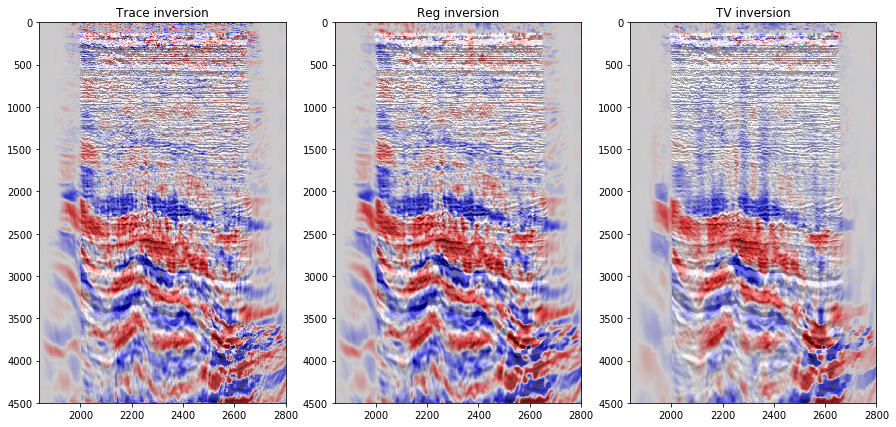

In [244]:
imodel = 0

# Display data
fig, axs = plt.subplots(1, 3, figsize=(15, 7))
im = axs[0].imshow(dtheta[:, 10].T, cmap='gray', vmin=-0.05*d.max(), vmax=0.05*d.max(),
                extent=(fv.xlines[0], fv.xlines[-1], fv.samples[-1], fv.samples[0]))
axs[0].imshow(minv_dense[:, imodel], cmap='seismic', alpha=0.6, vmin=-0.3*minv_dense.max(),
              vmax=0.3*minv_dense.max(), extent=(fv.xlines[0], fv.xlines[-1], fv.samples[-1], fv.samples[0]))
axs[0].set_title('Trace inversion')
axs[0].axis('tight');

im = axs[1].imshow(dtheta[:, 10].T, cmap='gray', vmin=-0.05*d.max(), vmax=0.05*d.max(),
                extent=(fv.xlines[0], fv.xlines[-1], fv.samples[-1], fv.samples[0]))
axs[1].imshow(minv_reg[:, imodel], cmap='seismic', alpha=0.6, vmin=-0.3*minv_reg.max(),
          vmax=0.3*minv_reg.max(), extent=(fv.xlines[0], fv.xlines[-1], fv.samples[-1], fv.samples[0]))
axs[1].set_title('Reg inversion')
axs[1].axis('tight');

im = axs[2].imshow(dtheta[:, 10].T, cmap='gray', vmin=-0.05*d.max(), vmax=0.05*d.max(),
                extent=(fv.xlines[0], fv.xlines[-1], fv.samples[-1], fv.samples[0]))
axs[2].imshow(minv_blocky[:, imodel], cmap='seismic', alpha=0.6, vmin=-0.3*minv_blocky.max(),
          vmax=0.3*minv_blocky.max(), extent=(fv.xlines[0], fv.xlines[-1], fv.samples[-1], fv.samples[0]))
axs[2].set_title('TV inversion')
axs[2].axis('tight');